# Sprint 2

We will start with the images

first, Import the usual stuff

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from fastai.vision.all import *
import matplotlib.pyplot as plt

## resizing our images

we will do this once (in parallel) and then save them so the next time we load our images it doesn't take so loooong

In [5]:

original_path = Path('tripadvisor_dataset/tripadvisor_images')



trns_path = Path('tripadvisor_dataset/tripadvisor_images_small')
trns_path.mkdir(exist_ok=True)

In [6]:
if os.listdir(trns_path)==[]:
    resize_images(original_path, max_workers=4, dest=trns_path, max_size=256)

## splitting our image data
to make a train-test split we make sure that a restaurant appears in our testset or our image set, not on both. This is to make sure that the models we create will learn information from the images and not information that is typical for a restaurant. For example restaurant A has all of it's food images taken on a blue background. Then our model can start associating certain information with the blue background and not with the food. so that's why we split it, just to be sure

In [39]:
img_folder = "./tripadvisor_dataset/tripadvisor_images_small"
images=os.listdir(img_folder)
# images=[x[:x.find("_")] for x in images]
images[:20]

['10020994_0.jpg',
 '10020994_1.jpg',
 '10020994_2.jpg',
 '10020994_3.jpg',
 '10020994_4.jpg',
 '10020994_5.jpg',
 '10020994_6.jpg',
 '10020994_7.jpg',
 '10025700_0.jpg',
 '10025700_1.jpg',
 '10025700_2.jpg',
 '10025700_3.jpg',
 '10025700_4.jpg',
 '10025700_5.jpg',
 '10025700_6.jpg',
 '10025700_7.jpg',
 '10025700_8.jpg',
 '10025700_9.jpg',
 '10027323_0.jpg',
 '10027323_1.jpg']

we notice that the images are sorted so it's easier to split them, we will split then in a 20/80 ratio

In [42]:
print(len(images)*0.8)

12146.400000000001


In [43]:
images[12140:12150]

['740601_4.jpg',
 '740601_5.jpg',
 '740601_6.jpg',
 '740601_7.jpg',
 '740601_8.jpg',
 '740601_9.jpg',
 '740609_0.jpg',
 '740609_1.jpg',
 '740609_2.jpg',
 '740609_3.jpg']

split it on 740609_0.jpg

In [49]:

split_index=images.index("740609_0.jpg")
train_images=images[:split_index]
test_images=images[split_index:]
traindir = Path('tripadvisor_dataset/tripadvisor_images_train')
testdir = Path('tripadvisor_dataset/tripadvisor_images_test')
if not os.path.exists(traindir):
    os.mkdir(traindir)
    os.mkdir(testdir)
    for trainimg in train_images:
        shutil.copy2(os.path.join(img_folder,trainimg),os.path.join(traindir,trainimg))
    for testimg in test_images:
        shutil.copy2(os.path.join(img_folder,trainimg),os.path.join(testdir,trainimg))

## Creating our dataset

In [2]:

IMG_HEIGHT = 128
IMG_WIDTH = 128


let's look at some images

((550, 413), (550, 550))

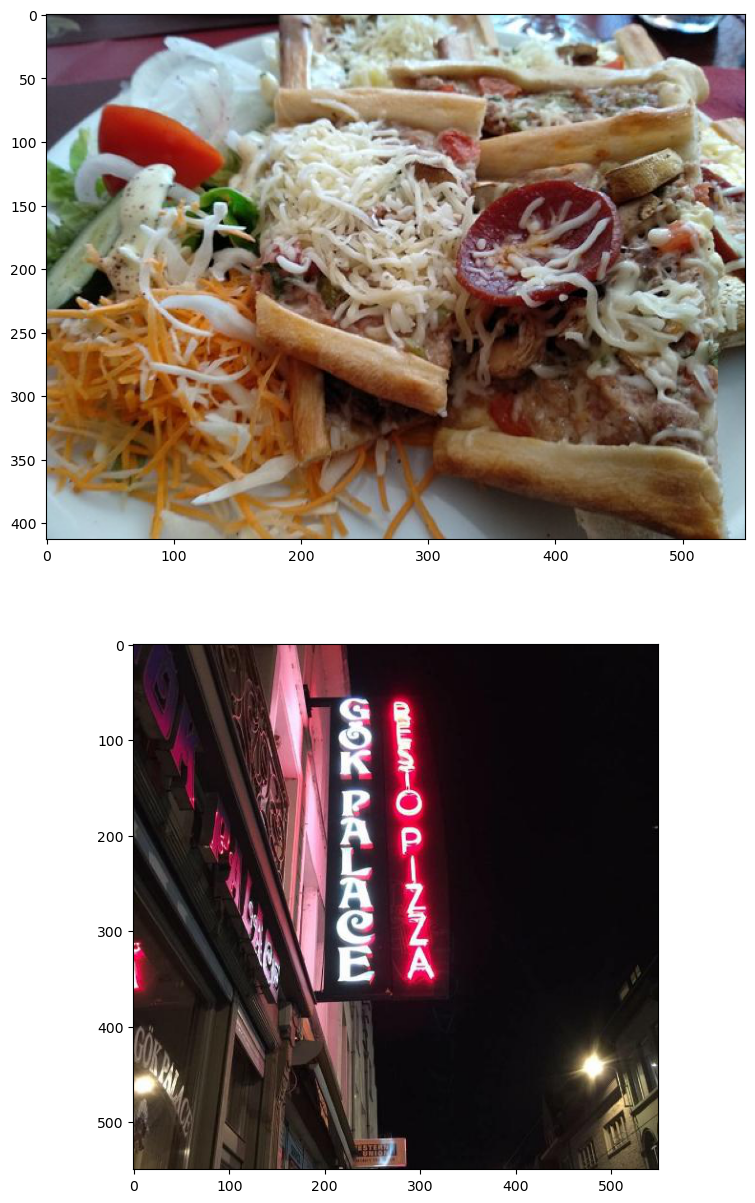

In [3]:
image_files=os.listdir(traindir)
fig=plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
img1=PILImage.create(os.path.join(traindir,image_files[0]))
plt.imshow(img1)
plt.subplot(2,1,2)
img2=PILImage.create(os.path.join(traindir,image_files[1]))
plt.imshow(img2)
img1.size,img2.size

We can already see that our images have different sizes and not all of our pictures are pictures of food. So let's resize them

In [4]:

def create_dataset(img_folder, n=None):
    image_files=os.listdir(os.path.join(img_folder))
    if n==None:
        n=len(image_files)
    images = np.zeros((n, IMG_HEIGHT* IMG_WIDTH* 3))
    for i,file in enumerate(image_files[:n]):
        # print(f"{i},{file}")
        img=PILImage.create(os.path.join(img_folder,file))
        img_resized=img.resize((IMG_HEIGHT,IMG_WIDTH))
        img_np=np.array(img_resized).flatten()
        images[i]=img_np/255
    return images



In [5]:

images = create_dataset(traindir,50)


lets look at some of our cropped images

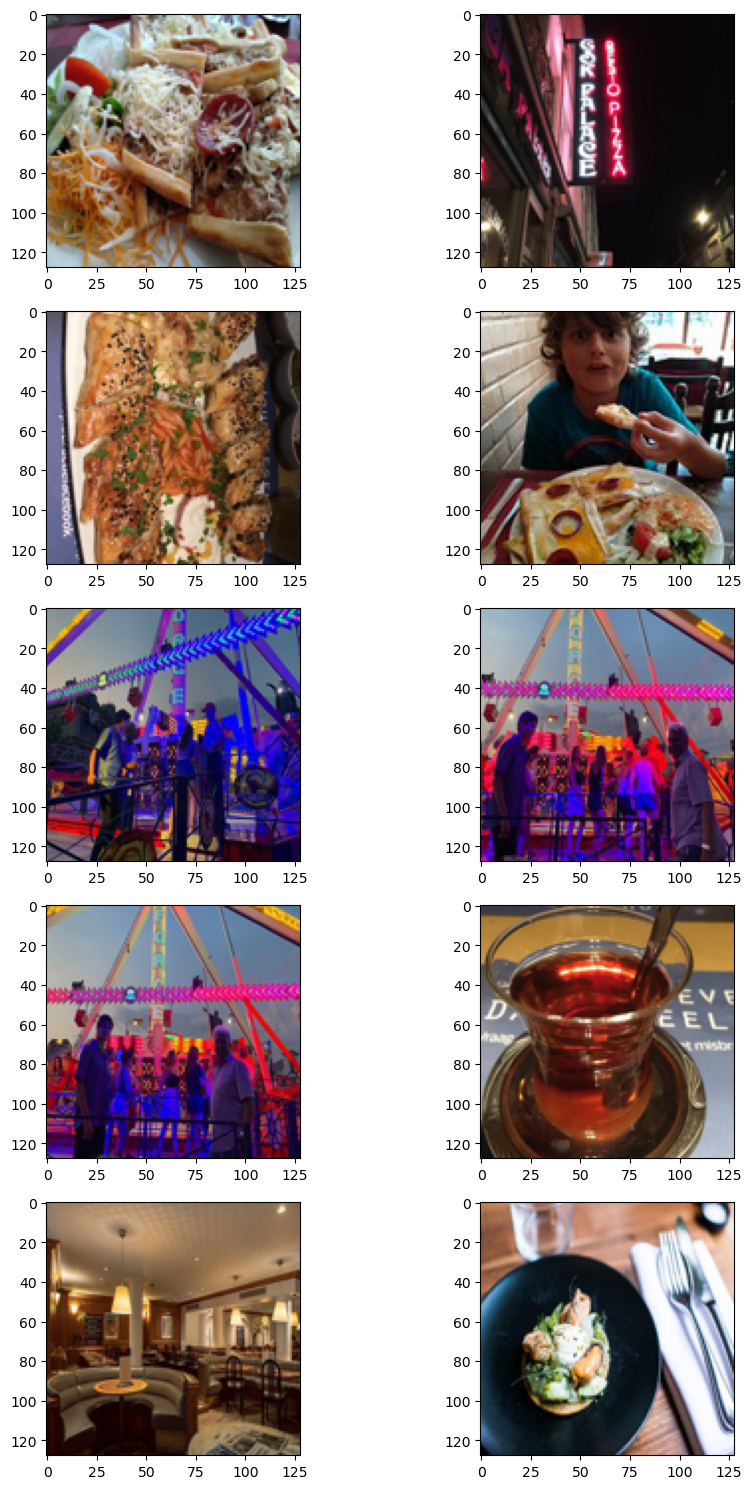

In [8]:
fig=plt.figure(figsize=(10,15))
for i in range(0,10):
    plt.subplot(5,2,i+1)
    plt.imshow(images[i].reshape(IMG_HEIGHT,IMG_WIDTH,3))
fig.tight_layout()
plt.show()

not all of these images are usefull, we will have to find a way to clean our dataset because we know, garbage in is garbage out

we will first start with feature extraction followed by an initial clustering to find a way to separate the food images from the non food images

In [22]:
# from fastai.data.external import *
# from fastai.vision.all import *

# probimage="tripadvisor_dataset/tripadvisor_images/10154986_8.jpg"
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))

# img=PILImage.create(probimage)
# ax1.imshow(img)
# img_resized=img.resize((IMG_HEIGHT, IMG_WIDTH))
# ax2.imshow(img_resized)
# print(img_resized.size)
# img_np=np.array(img_resized).flatten()
# print(img_np.shape)

# img=cv2.imread(probimage)
# ax1.imshow(img)
# img_resized=cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
# ax2.imshow(img_resized)
# print(img_resized.size)
# img_np=np.array(img_resized).flatten()
# print(img_np.shape)


## Feature extraction
we will start with the basic HOG algorithm that we have seen in our lab

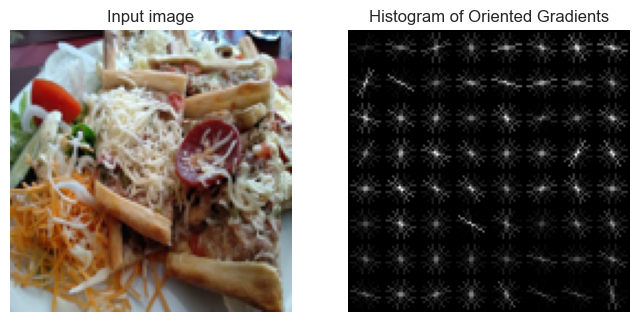

In [23]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

img = images[0].reshape(IMG_HEIGHT,IMG_WIDTH,3)

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

this is what we get from 1 picture, now let's apply it to our whole dataset

In [24]:
images_hogs = np.zeros((images.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images), total=len(images)):
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel], orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_hogs[i, channel*512:channel*512+512] = fd


100%|██████████| 50/50 [00:00<00:00, 69.83it/s]


In [26]:
images_hogs.shape

(50, 1536)

## Clustering
but we will start with standardizing our data

In [16]:
from sklearn.preprocessing import StandardScaler
# scale hog features
sc = StandardScaler()
hogs_scaled = sc.fit_transform(images_hogs)

before we start with dimensionality reduction we will make an initial clustering to get to know our data better and see if it's easy to separate the food images from the non food images


In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0)
predictions = kmeans.fit_predict(hogs_scaled)

d:\programmas_unif\miniconda\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
d:\programmas_unif\miniconda\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


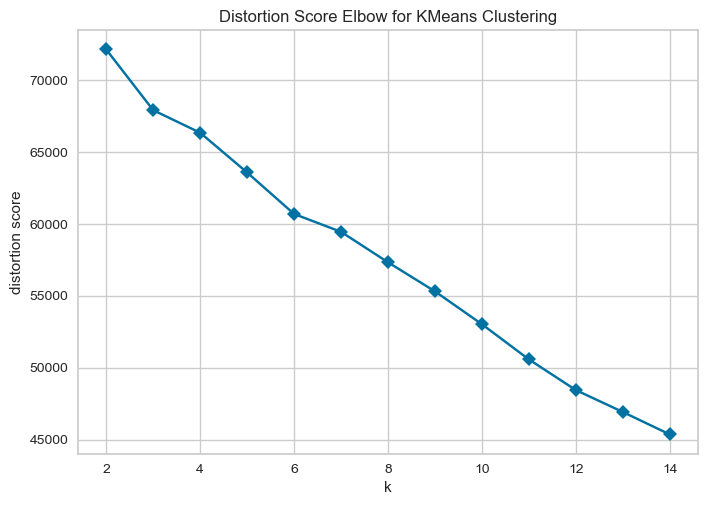

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualiser = KElbowVisualizer(model, k=(2,15), timings=False)

visualiser.fit(hogs_scaled)
visualiser.show()

not really a good sign, it doesn't have the distict elbow shape, maybe it's because of our feature extraction. We try it again without the hogs but on our raw pixel data

d:\programmas_unif\miniconda\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
d:\programmas_unif\miniconda\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


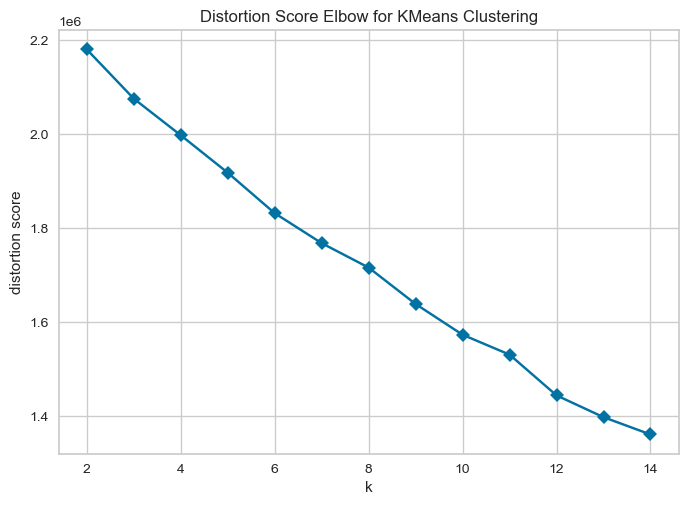

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualiser = KElbowVisualizer(model, k=(2,15), timings=False)

visualiser.fit(StandardScaler().fit_transform(images))
visualiser.show()

still the same

CLUSTER 0


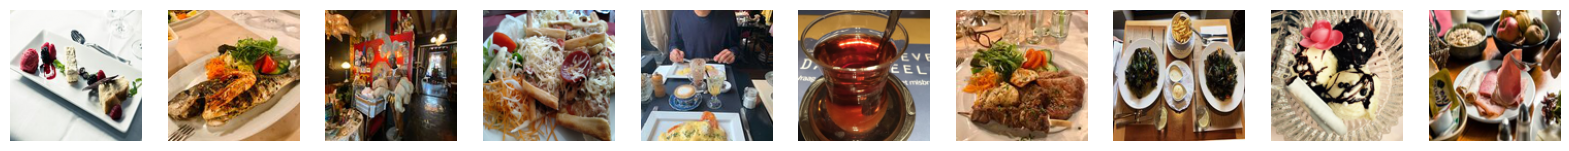

CLUSTER 1


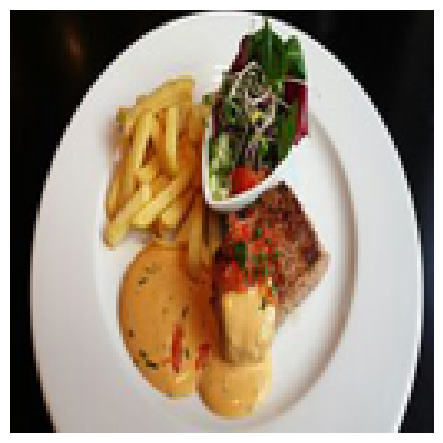

In [30]:
# you can optionally give this function the distances of the instances to the cluster centers (obtainable by using the models transform function)
def show_predictions(predictions, n_clusters, images, distances=None):
    for cluster in range(n_clusters):
        print(f"CLUSTER {cluster}")

        cluster_images = images[np.where(predictions == cluster)]

        if distances is not None:
            # we sort the images so that they are displayed in order of distance to cluster center
            cluster_distances=  np.min(distances[np.where(predictions == cluster)], axis=1)
            cluster_instances_sorted = np.argsort(cluster_distances)
            cluster_images = cluster_images[cluster_instances_sorted[::-1]]
                
        num_pics = 10 if cluster_images.shape[0] > 10 else cluster_images.shape[0]

        # try to pick out images closes to the cluster centers
        if num_pics == 0:
            print("No images in this cluster")
            continue
        if num_pics == 1:
            plt.figure()
            plt.imshow(cluster_images[0].reshape((128,128,3)))
            plt.axis("off")
            plt.show()
            continue
        indices = np.random.choice(np.arange(cluster_images.shape[0]), num_pics, replace=False)
        _, axs = plt.subplots(1, num_pics, figsize=(20,20))
        axs = axs.flatten()
        for img, ax in zip(cluster_images[indices], axs):
            ax.imshow(img.reshape((128,128,3)))
            ax.set_axis_off()
        plt.show()

show_predictions(predictions, 2, images)

## SURF

In [29]:
# import cv2
# image = cv2.imread(r'tripadvisor_dataset/tripadvisor_images/694642_0.jpg', cv2.COLOR_BGR2RGB)[..., ::-1] # convert BRG to RGB
# # sift = cv2.xfeatures2d.SIFT_create()
# surf = cv2.xfeatures2d.SURF_create()
# image


Image


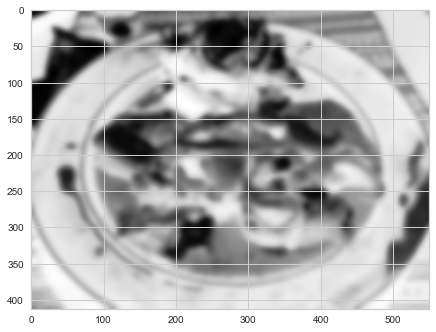

No of  points: 316


(316, 70)

In [42]:
import mahotas
import mahotas.demos
import mahotas as mh
import numpy as np
from pylab import imshow, show
from mahotas.features import surf
import cv2
 
# loading image
image = cv2.imread(r'tripadvisor_dataset/tripadvisor_images/694642_0.jpg', cv2.COLOR_BGR2RGB)[..., ::-1]

# removing color
nuclear = image[:, :, 0]
 
# adding gaussian filter
nuclear = mahotas.gaussian_filter(nuclear, 4)
 
# showing image
print("Image")
# imshow(image)
imshow(nuclear)

show()
 
 
# getting Speeded-Up Robust Features
spoints = surf.surf(nuclear)
print("No of  points: {}".format(len(spoints)))
spoints.shape

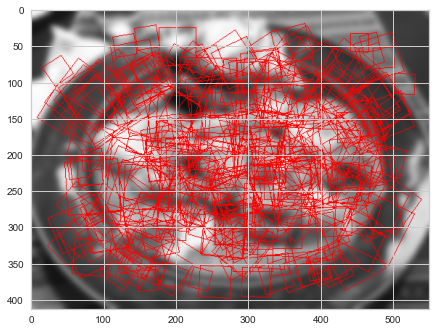

In [44]:
f2 = surf.show_surf(nuclear, spoints)
imshow(f2)

In [54]:
descrs = spoints[:,5:]
descrs

array([[-6.81544293e-02, -2.70098801e-03, -4.04479730e-03, ...,
         6.76838827e-03,  3.45942610e-03,  6.87935334e-03],
       [ 8.52558173e-01, -1.86376353e-03,  2.71579987e-04, ...,
        -8.44426238e-03,  3.72934355e-03,  8.81986722e-03],
       [-4.08073071e-02, -1.53807184e-03,  4.69340749e-04, ...,
         2.67600569e-03,  1.29519685e-02,  1.16461087e-02],
       ...,
       [-1.08154917e+00, -1.99051028e-03, -2.45797054e-03, ...,
         5.15807409e-02,  1.97307078e-02,  5.15807409e-02],
       [-2.66805772e+00, -1.27394332e-03, -1.19801443e-03, ...,
        -8.06954759e-03,  2.52451035e-03,  8.06954759e-03],
       [ 2.24367622e+00,  7.89519269e-04,  5.56314620e-03, ...,
         1.10827850e-02,  2.91387475e-03,  1.10827850e-02]])

Dense Image


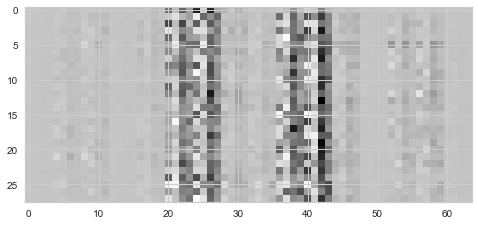

In [60]:
dense_img = surf.dense(nuclear, 50)
 
# showing image
print("Dense Image")
imshow(dense_img)
show()